In [1]:
# import statements
import pandas as pd
import numpy as np
from pandas import value_counts
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
import os

In [2]:
# read csv as data frame 
df = pd.read_csv("coupon.csv")

print(df.shape)

# gives count, mean, srd, min, 25 percentile, 50 percentile, 75 percentile, max
df.info()

(12684, 26)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12684 entries, 0 to 12683
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   destination           12684 non-null  object
 1   passanger             12684 non-null  object
 2   weather               12684 non-null  object
 3   temperature           12684 non-null  int64 
 4   time                  12684 non-null  object
 5   coupon                12684 non-null  object
 6   expiration            12684 non-null  object
 7   gender                12684 non-null  object
 8   age                   12684 non-null  object
 9   maritalStatus         12684 non-null  object
 10  has_children          12684 non-null  int64 
 11  education             12684 non-null  object
 12  occupation            12684 non-null  object
 13  income                12684 non-null  object
 14  car                   108 non-null    object
 15  Bar                   12

In [3]:
# drop cars as it is mostly blank (108 are blank, 12576 are empty)
df = df.drop(columns=['car'])

# drop direction_opp as it is inverse of direction_same so its redundant
df = df.drop(columns=['direction_opp'])

# print number of duplicates
print("num duplicates", df.duplicated().sum())

df.isnull().sum()

num duplicates 74


destination               0
passanger                 0
weather                   0
temperature               0
time                      0
coupon                    0
expiration                0
gender                    0
age                       0
maritalStatus             0
has_children              0
education                 0
occupation                0
income                    0
Bar                     107
CoffeeHouse             217
CarryAway               151
RestaurantLessThan20    130
Restaurant20To50        189
toCoupon_GEQ5min          0
toCoupon_GEQ15min         0
toCoupon_GEQ25min         0
direction_same            0
Y                         0
dtype: int64

# Blanks and Duplicates
|column|number of blanks|most common class|
|------|----------------|-----------------|
|bar|107|never (5k)|
|CoffeeHouse|217|less1 (3.3k), 1~3 (3.2k)|
|CarryAway|151|1~3 (4.6k), 4~8 (4.3k)|
|RestaurantLessThan20|130|1~3(5.3k), 4~8 (3.5k)|
|Restaurant20To50|189|1~3 (5.3k), 4~8 (3.5k)|

### Other observations
- There are 74 duplicates
- There 42 common blanks between these 5

In [4]:
# drop duplicates
df = df.drop_duplicates()

# list of columns with blank values
blank_columns = ['Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50']

# delete 42 common null values
df.dropna(subset=blank_columns, how='all', inplace=True)

df.isnull().sum()

destination               0
passanger                 0
weather                   0
temperature               0
time                      0
coupon                    0
expiration                0
gender                    0
age                       0
maritalStatus             0
has_children              0
education                 0
occupation                0
income                    0
Bar                      65
CoffeeHouse             175
CarryAway               108
RestaurantLessThan20     87
Restaurant20To50        147
toCoupon_GEQ5min          0
toCoupon_GEQ15min         0
toCoupon_GEQ25min         0
direction_same            0
Y                         0
dtype: int64

In [5]:
# null impute based on average probalistic weightage in each of the classes
for column in blank_columns:
    weights = df[column].value_counts(normalize=True)
    df[column].fillna(pd.Series(np.random.choice(weights.index, size=len(df.index), p=weights.values.tolist())), inplace=True)

df.isnull().sum()

destination             0
passanger               0
weather                 0
temperature             0
time                    0
coupon                  0
expiration              0
gender                  0
age                     0
maritalStatus           0
has_children            0
education               0
occupation              0
income                  0
Bar                     0
CoffeeHouse             0
CarryAway               0
RestaurantLessThan20    0
Restaurant20To50        0
toCoupon_GEQ5min        0
toCoupon_GEQ15min       0
toCoupon_GEQ25min       0
direction_same          0
Y                       0
dtype: int64

# Encoding
| Column Name | Data Type |
|-------------|-----------|
| destination | nominal   |
| passanger   | nominal   |
| weather     | nominal   |
| temperature | ordinal   |
| time        | ordinal   |
| coupon      | nominal   |
| expiration  | ordinal   |
| gender      | nominal   |
| age         | ordinal   |
| maritalStatus | nominal |
| has_children | encoded  |
| education   | ordinal   |
| occupation  | nominal   |
| income      | ordinal   |
| Bar         | ordinal   |
| CoffeeHouse | ordinal   |
| CarryAway   | ordinal   |
| RestaurantLessThan20 | ordinal |
| Restaurant20To50 | ordinal |
| toCoupon_GEQ5min | encoded |
| toCoupon_GEQ15min | encoded |
| toCoupon_GEQ25min | encoded |
| direction_opp | encoded  |

In [6]:
# Ordinal Encoding

# a common classes order for all some columns
amount_visited_order = ['never','less1','1~3','4~8','gt8']

# ordinal columns with their categories in order
ordinal_columns = [('temperature',['30','55','80']), 
                   ('time', ['7AM', '10AM', '2PM', '6PM', '10PM']), 
                   ('expiration', ['2h', '1d']),
                   ('gender', ['Male', 'Female']), # since its 2 values we can do ordinal encoding
                   ('age', ['below21','21','26','31','36','41','46','50plus']), 
                   ('education', ['Some High School', 'High School Graduate', 'Some college - no degree', 'Associates degree', 'Bachelors degree', 'Graduate degree (Masters or Doctorate)']),
                   ('income', ['Less than $12500','$12500 - $24999','$25000 - $37499','$37500 - $49999','$50000 - $62499','$62500 - $74999','$75000 - $87499','$87500 - $99999','$100000 or More']),
                   ('Bar', amount_visited_order),
                   ('CoffeeHouse', amount_visited_order),
                   ('CarryAway', amount_visited_order),
                   ('RestaurantLessThan20', amount_visited_order),
                   ('Restaurant20To50', amount_visited_order)]

# apply the ordinal encoding
for column, categories in ordinal_columns:
    df[column] =  OrdinalEncoder(categories=[categories]).fit_transform(df[[column]])

# to check if it worked
# df.to_csv(os.path.join('PreprocessingData',"coupon_processed_2.csv"), index=False)

In [7]:
df['occupation'].value_counts()

occupation
Unemployed                                   1849
Student                                      1575
Computer & Mathematical                      1372
Sales & Related                              1088
Education&Training&Library                    939
Management                                    815
Office & Administrative Support               638
Arts Design Entertainment Sports & Media      627
Business & Financial                          537
Retired                                       493
Food Preparation & Serving Related            298
Healthcare Practitioners & Technical          244
Healthcare Support                            242
Community & Social Services                   239
Legal                                         219
Transportation & Material Moving              218
Architecture & Engineering                    175
Personal Care & Service                       175
Protective Service                            174
Life Physical Social Science           

In [8]:
# Nominal Encoding

nomimal_columns = ['destination', 'passanger', 'weather', 'coupon', 'maritalStatus', 'occupation']

for column in nomimal_columns:
    df = pd.get_dummies(df, columns=[column]) # type: ignore

# to check if it worked
# df.to_csv(os.path.join('PreprocessingData',"coupon_processed_2.csv"), index=False)


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12568 entries, 0 to 12683
Data columns (total 63 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   temperature                                           12568 non-null  float64
 1   time                                                  12568 non-null  float64
 2   expiration                                            12568 non-null  float64
 3   gender                                                12568 non-null  float64
 4   age                                                   12568 non-null  float64
 5   has_children                                          12568 non-null  int64  
 6   education                                             12568 non-null  float64
 7   income                                                12568 non-null  float64
 8   Bar                                                   12568 n

# Classification

In [10]:
# for machine learning, we need arrays so we extract y as array
y = df["Y"].to_numpy()

# drop the target column
df = df.drop(columns=["Y"]) 

# extract x as array
x = df.to_numpy()

## Decision Tree Classifier

In [11]:
# split into training (80%) and testing (20%)
x_train, x_test, y_train, y_test, = train_test_split(x,y, test_size=0.2)

# Create classifier decision tree
from sklearn.tree import DecisionTreeClassifier

# create decision tree classifer object
dtc = DecisionTreeClassifier()

# train decision tree classifer
dtc.fit(x_train, y_train)

# predict the response for test dataset
y_predicted = dtc.predict(x_test)

# check accuracy
print(f"training accuracy {dtc.score(x_train, y_train)}")
print(f"testing accuracy {dtc.score(x_test, y_test)}")

print(f"node count {dtc.tree_.node_count}")
print(f"depth {dtc.get_depth()}")
print(f"number of leaves {dtc.get_n_leaves()}")

training accuracy 0.9987069822956037
testing accuracy 0.677406523468576
node count 5225
depth 24
number of leaves 2613


## Hyper Parameter Tuning

In [12]:
#tune

def tune(start, stop, step, dtc, x, y, tuning_range=None):
    data = []
    current_percent = 10
    start_time = time.time()
    if tuning_range is None:
        tuning_range = range(start, stop, step) if type(start) == int else np.arange(start, stop, step)
    for i in tuning_range:
        node_count = []
        testing_accuracy = []
        training_accuracy = []
        for _ in range(50):
            
            # create decision tree classifer object
            dtc_tune = dtc(i)

            # split data
            x_train, x_test, y_train, y_test, = train_test_split(x,y, test_size=0.2)

            # train decision tree classifer
            dtc_tune.fit(x_train, y_train)

            # get traning and testing accuracy
            node_count.append(dtc_tune.tree_.node_count)
            training_accuracy.append(dtc_tune.score(x_train, y_train))
            testing_accuracy.append(dtc_tune.score(x_test, y_test))

        
        # get average of 50 runs
        node_count = sum(node_count) / len(node_count)
        training_accuracy = sum(training_accuracy) / len(training_accuracy)
        testing_accuracy = sum(testing_accuracy) / len(testing_accuracy)

        data.append([i, node_count, training_accuracy, testing_accuracy])

        if start != 0 and stop != 0 and step != 0:
            if (i - start) // step > ((stop - start) // step + 1) * current_percent/100:
                print(f"{current_percent}% done at {(time.time()-start_time)/60} minutes")
                current_percent += 10

    return data


def plot(data, title):
    # convert data to data frame
    df = pd.DataFrame(data, columns=["param", "node_count", "training_accuracy", "testing_accuracy"])

    # plot node count vs training accuracy and testing accuracy and label the graph
    df.drop(columns=['param']).plot(x="node_count", y=["training_accuracy", "testing_accuracy"])
    plt.xlabel("node count")
    plt.ylabel("accuracy")
    plt.title(title)
    plt.show()

def save_to_csv(model, name):
    df = pd.DataFrame(model, columns=[name, "node_count", "training_accuracy", "testing_accuracy"])
    df.to_csv(os.path.join("TuningData", name + ".csv"), index=False)
    return df

10% done at 2.496693746248881 minutes
20% done at 4.174413998921712 minutes
30% done at 6.101744345823923 minutes
40% done at 7.8190298517545065 minutes
50% done at 9.360670506954193 minutes
60% done at 10.950840512911478 minutes
70% done at 12.45088760058085 minutes
80% done at 13.933253002166747 minutes
90% done at 15.453030622005462 minutes


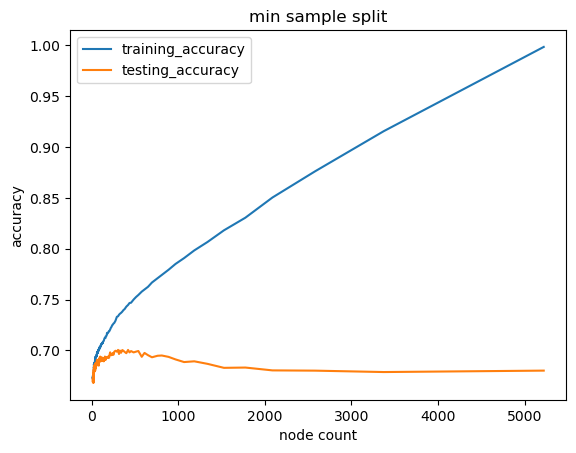

In [31]:
# min sample split
min_sample_split = tune(2, 2000, 5, lambda i: DecisionTreeClassifier(min_samples_split=i), x, y)
plot(min_sample_split, "min sample split")

min_sample_split_df = save_to_csv(min_sample_split, "min_sample_split")


In [34]:
# criterion{“gini”, “entropy”, “log_loss”}

criterion = tune(0, 0, 0, lambda i: DecisionTreeClassifier(criterion=i), x, y, ["gini", "entropy", "log_loss"])

criterion_df = save_to_csv(criterion, "criterion")

criterion_df.head()

,criterion,node_count,training_accuracy,testing_accuracy
0,gini,5217.72,0.998580,0.681010
1,entropy,5158.76,0.998613,0.681440
2,log_loss,5157.60,0.998600,0.678775


In [35]:
# splitter{“best”, “random”}

splitter = tune(0, 0, 0, lambda i: DecisionTreeClassifier(splitter=i), x, y, ["best", "random"])

splitter_df = save_to_csv(splitter, "splitter")

splitter_df.head()

,splitter,node_count,training_accuracy,testing_accuracy
0,best,5218.12,0.998580,0.678417
1,random,5688.72,0.998548,0.677208


10% done at 0.1374037782351176 minutes
20% done at 0.3339982231458028 minutes
30% done at 0.5876027743021647 minutes
40% done at 0.8711051980654398 minutes
50% done at 1.1692479372024536 minutes
60% done at 1.5410183787345886 minutes
70% done at 1.888843293984731 minutes
80% done at 2.2697699268658957 minutes
90% done at 2.665275998910268 minutes


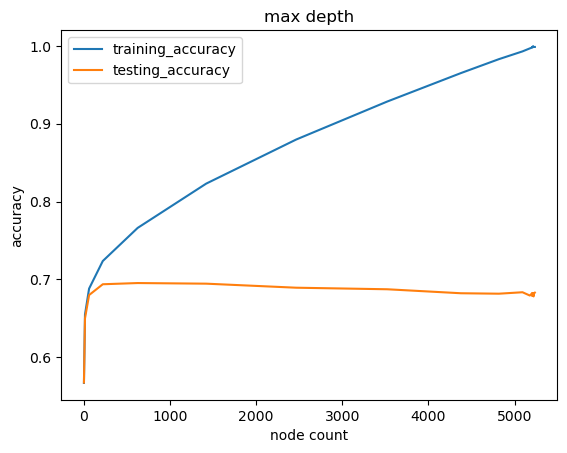

In [33]:
# max_depth
# with default params: 41
max_depth = tune(1, 60, 2, lambda i: DecisionTreeClassifier(max_depth=i), x, y)
plot(max_depth, "max depth")

max_depth_df = save_to_csv(max_depth, "max_depth")

10% done at 1.8019763787587484 minutes
20% done at 3.369365632534027 minutes
30% done at 4.543634645144144 minutes
40% done at 5.459102034568787 minutes
50% done at 6.488441677888234 minutes
60% done at 7.5128466526667275 minutes
70% done at 8.647308758894603 minutes
80% done at 9.669619989395141 minutes
90% done at 10.387109939257304 minutes


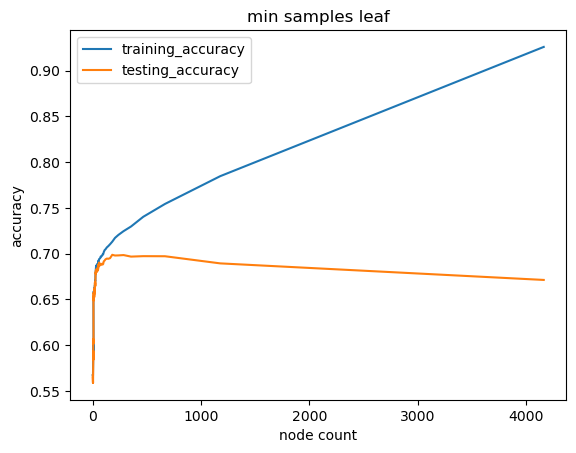

In [13]:
# min_samples_leaf 
# The minimum number of samples required to split an internal node:
min_samples_leaf = tune(2, 5000, 10, lambda i: DecisionTreeClassifier(min_samples_leaf=i), x, y)
plot(min_samples_leaf, "min samples leaf")

min_samples_leaf_df = save_to_csv(min_samples_leaf, "min_samples_leaf")


10% done at 0.276308004061381 minutes
20% done at 0.3943569223086039 minutes
30% done at 0.4673693855603536 minutes
40% done at 0.5628462831179301 minutes
50% done at 0.6213066418965657 minutes
60% done at 0.6939525564511617 minutes
70% done at 0.7884620229403178 minutes
80% done at 0.8695732553799947 minutes
90% done at 0.9709781765937805 minutes


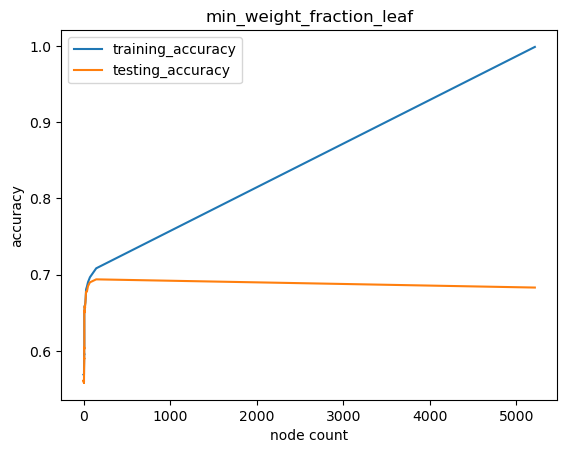

In [40]:
# min_weight_fraction_leaf
# The minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node. 
# Samples have equal weight when sample_weight is not provided.

min_weight_fraction_leaf = tune(0.0, 0.5, 0.01, lambda i: DecisionTreeClassifier(min_weight_fraction_leaf=i), x, y)
plot(min_weight_fraction_leaf, "min_weight_fraction_leaf")

min_weight_fraction_leaf_df = save_to_csv(min_weight_fraction_leaf, "min_weight_fraction_leaf")

10% done at 0.2678362250328064 minutes
20% done at 0.6002991835276286 minutes
30% done at 0.9800418496131897 minutes
40% done at 1.4599990526835123 minutes
50% done at 1.9263035694758097 minutes
60% done at 2.45808478196462 minutes
70% done at 3.1306989590326944 minutes
80% done at 3.749065065383911 minutes
90% done at 4.418381694952647 minutes


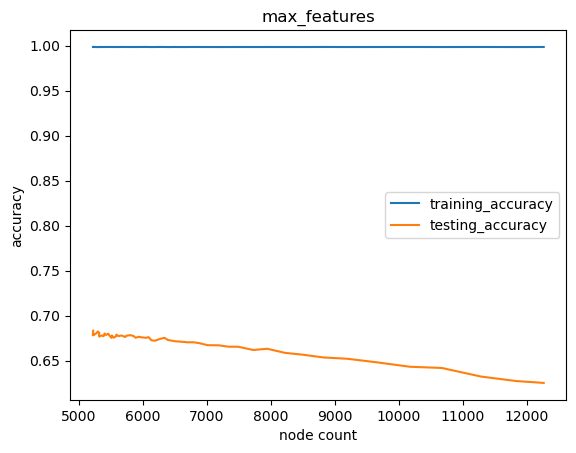

In [38]:
# max_features
# If int, then consider max_features features at each split.
max_features = tune(1, x.shape[1]+1, 1, lambda i: DecisionTreeClassifier(max_features=i), x, y)
plot(max_features, "max_features")

max_features_df = save_to_csv(max_features, "max_features")

In [39]:
# max features special
# If “sqrt”, then max_features=sqrt(n_features).
# If “log2”, then max_features=log2(n_features).

max_features_special = tune(0, 0, 0, lambda i: DecisionTreeClassifier(max_features=i), x, y, ["sqrt", "log2"])

max_features_special_df = save_to_csv(max_features_special, "max_features_special")

max_features_special_df.head()

,max_features_special,node_count,training_accuracy,testing_accuracy
0,sqrt,9234.24,0.998584,0.653771
1,log2,10122.28,0.998617,0.646213


10% done at 1.5079924742380777 minutes
20% done at 4.076487946510315 minutes
30% done at 7.879792392253876 minutes
40% done at 12.481411735216776 minutes
50% done at 17.558267656962077 minutes
60% done at 22.317478442192076 minutes
70% done at 27.23013897339503 minutes
80% done at 32.31967889467875 minutes
90% done at 37.97249312400818 minutes


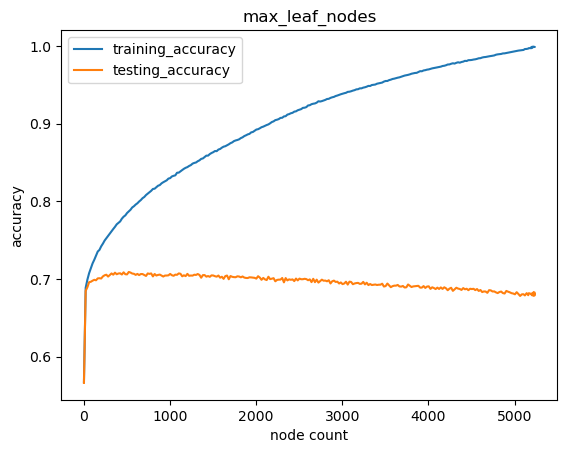

In [42]:
# max_leaf_nodes
# with default params: 2716

max_leaf_nodes = tune(2, 3000, 10, lambda i: DecisionTreeClassifier(max_leaf_nodes=i), x, y)
plot(max_leaf_nodes, "max_leaf_nodes")

max_leaf_nodes_df = save_to_csv(max_leaf_nodes, "max_leaf_nodes")

10% done at 0.27959386507670086 minutes
20% done at 0.4411225914955139 minutes
30% done at 0.5704434196154277 minutes
40% done at 0.6900046308835347 minutes
50% done at 0.8259171724319458 minutes
60% done at 0.9455630461374919 minutes
70% done at 1.061566138267517 minutes
80% done at 1.169679335753123 minutes
90% done at 1.3197712341944376 minutes


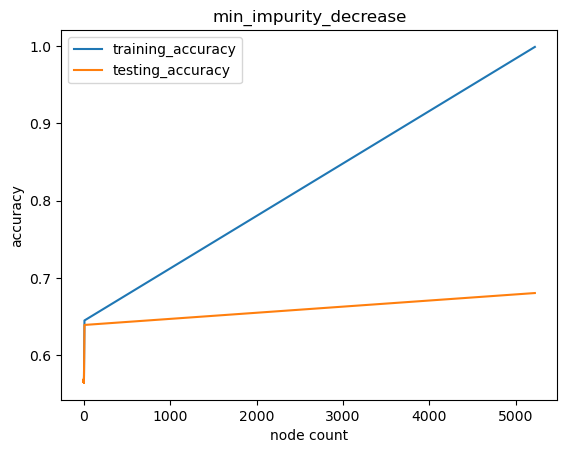

In [43]:
# min_impurity_decrease

min_impurity_decrease = tune(0.0, 1.0, 0.01, lambda i: DecisionTreeClassifier(min_impurity_decrease=i), x, y)
plot(min_impurity_decrease, "min_impurity_decrease")

min_impurity_decrease_df = save_to_csv(min_impurity_decrease, "min_impurity_decrease")

In [14]:
# min_impurity_decrease pt.2

min_impurity_decrease_2 = tune(0.0, 10.0, 0.1, lambda i: DecisionTreeClassifier(min_impurity_decrease=i), x, y)
plot(min_impurity_decrease_2, "min_impurity_decrease_2")

min_impurity_decrease_2_df = save_to_csv(min_impurity_decrease_2, "min_impurity_decrease_2")

KeyboardInterrupt: 

10% done at 2.4074595252672832 minutes
20% done at 4.1785123467445375 minutes
30% done at 5.8982315301895145 minutes
40% done at 7.225984255472819 minutes
50% done at 8.480105249087016 minutes
60% done at 9.6263241092364 minutes
70% done at 10.88953800201416 minutes
80% done at 12.131972074508667 minutes
90% done at 13.587274010976156 minutes


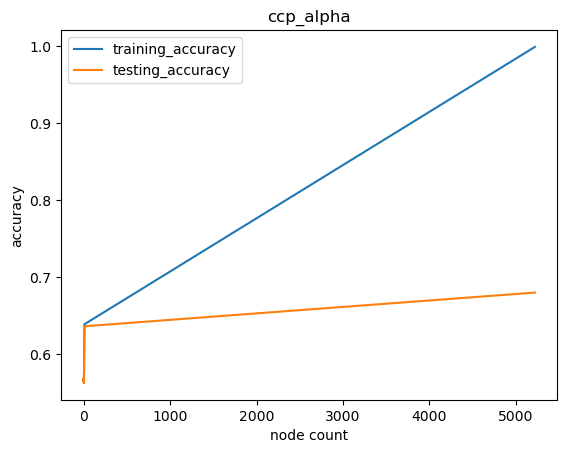

In [14]:
# ccp_alpha

ccp_alpha = tune(0.0, 1.0, 0.01, lambda i: DecisionTreeClassifier(ccp_alpha=i), x, y)
plot(ccp_alpha, "ccp_alpha")

ccp_alpha_df = save_to_csv(ccp_alpha, "ccp_alpha")

In [ ]:
# ccp_alpha pt.2

ccp_alpha_2 = tune(0.0, 10.0, 0.1, lambda i: DecisionTreeClassifier(ccp_alpha=i), x, y)
plot(ccp_alpha_2, "ccp_alpha_2")

ccp_alpha_2_df = save_to_csv(ccp_alpha_2, "ccp_alpha_2")

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Create a decision tree classifier object
dt = DecisionTreeClassifier(criterion='entropy',
                            splitter='best', 
                            max_depth=59, 
                            min_samples_split=167, 
                            min_samples_leaf=82, 
                            min_weight_fraction_leaf=0.02,
                            max_features=62, 
                            max_leaf_nodes=182, 
                            min_impurity_decrease=0.0, # idk
                            ccp_alpha=0.0) # idk
# Fit the decision tree classifier to the data
dt.fit(X_train, y_train)

# Predict the classes of the test set
y_pred = dt.predict(X_test)


In [25]:
# random forest
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()

x_train, x_test, y_train, y_test, = train_test_split(x,y, test_size=0.2)
rfc.fit(x_train, y_train)

print(f"testing accuracy {rfc.score(x_test, y_test)}")

testing accuracy 0.762132060461416
